# Understanding PolSpice

## Goal
The goal of this notebook is to recover full sky angular power spectra using the Polspice method as described in Camphius et al. (2204.13721) and Chon et al. (0303414). In order to do so, we will assume that we have observed a spin-2 complex field covering about 75% of the sky and measured its partial sky angular power spectra for the different fields ($\tilde{C}_\ell^{TT}$, $\tilde{C}_\ell^{EE}$ and $\tilde{C}_\ell;^{BB}$). We will also validate the reconstruction using full-sky theory predictions.




## Dependencies

In [1]:
!pip install healpy
!pip install camb==1.5.8

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import healpy as hp
import camb
import camb.correlations
from camb.correlations import gauss_legendre_correlation as glc

## Make data

We will use a Gaussian simulation to generate the map and then apply a square mask to it. The final masked map covers ~10% of the sky.

In [3]:
nside = 1024
lmax = 1000
bin_num = 15

In [4]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67., omch2=0.270*0.67**2, ombh2=0.049*0.67**2)
pars.InitPower.set_params(As=2.1e-9, ns=0.96)
pars.Want_CMB = False
pars.NonLinear = camb.model.NonLinear_both
pars.set_for_lmax(2*lmax, lens_potential_accuracy=1);

In [5]:
z = np.linspace(0, 3, 300)
nz = np.exp(-((0.3-z)/0.1)**2)
bz = 0.83070341 + 1.19054721*z - 0.92835749*z**2 + 0.42329232*z**3
sources = []
sources += [
    camb.sources.SplinedSourceWindow(source_type='counts', z=z, W=nz, bias_z=bz),
    camb.sources.SplinedSourceWindow(source_type='lensing', z=z, W=nz)]
pars.SourceWindows = sources

In [6]:
results = camb.get_results(pars)
camb_cls = results.get_source_cls_dict(lmax=lmax, raw_cl=True)

l = np.arange(lmax+1)
fl = -np.sqrt((l+2)*(l+1)*l*(l-1))
fl /= np.clip(l*(l+1), 1, None)

In [7]:
theory_cls = {}
theory_cls['BB'] = np.zeros(lmax+1)
theory_cls['EB'] = np.zeros(lmax+1)
theory_cls['EE'] = camb_cls['W2xW2'] * fl**2
theory_cls['TE'] = camb_cls['W2xW1'] * fl
theory_cls['TT'] = camb_cls['W1xW1']

:

In [8]:
theory_map = hp.sphtfunc.synfast([
        theory_cls['TT'],
        theory_cls['EE'],
        theory_cls['BB'] ,
        theory_cls['TE']],
        nside, new=True)

### Make Mask

In [9]:
mask = np.ones_like(theory_map[1])
pixel_theta, pixel_phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
mask_type = 'One third cover'

if mask_type == 'Patch':
    mask[np.pi/3 > pixel_theta] = 0.0
    mask[pixel_theta > 2*np.pi/3] = 0.0
    mask[pixel_phi > np.pi/2] = 0.0
    mask[np.pi/8> pixel_phi] = 0.0

if mask_type == 'One third cover':
    mask[np.pi/3 > pixel_theta] = 0.0

if mask_type == 'Half cover':
        mask[np.pi/2 > pixel_theta] = 0.0

if mask_type == 'Two thirds cover':
        mask[2*np.pi/3 > pixel_theta] = 0.0

if mask_type == 'None':
    mask = np.ones_like(theory_map[1])

maps = {
    'T': theory_map[0]*mask,
    'Q': theory_map[1]*mask,
    'U': theory_map[2]*mask
}

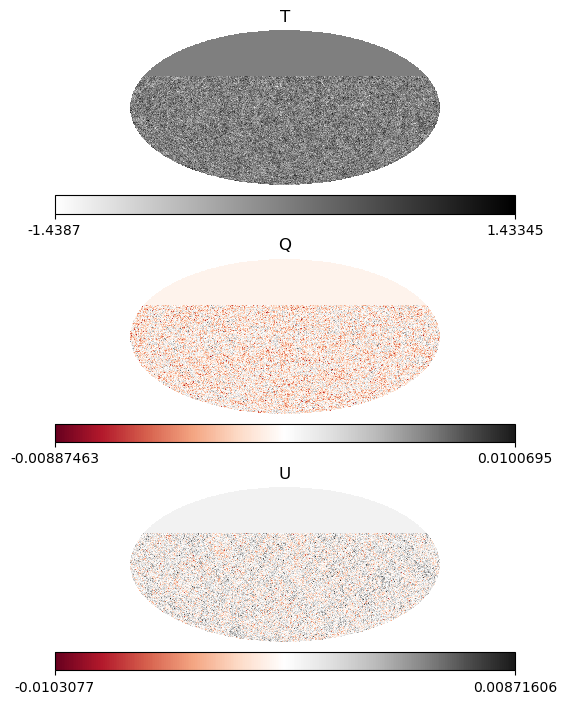

In [10]:
fig, ax = plt.subplots(3, figsize=(20, 7))
fig.tight_layout()
plt.sca(ax[0])
hp.mollview(maps['T'], cmap='binary', title='T', hold=True)
plt.sca(ax[1])
hp.mollview(maps['Q'], cmap='RdGy', title='Q', hold=True)
plt.sca(ax[2])
hp.mollview(maps['U'], cmap='RdGy', title='U', hold=True)
plt.show()

In [11]:
print("fsky: ", np.mean(mask))

fsky:  0.7501627604166666


### Make Cls

In [12]:
mask_cls = hp.anafast(mask, lmax=lmax)

In [13]:
data_cls_list = hp.anafast([maps['T'], maps['Q'], maps['U']], lmax=lmax)

In [14]:
data_cls = {
    'TT': data_cls_list[0],
    'EE': data_cls_list[1],
    'BB': data_cls_list[2],
    'TE': data_cls_list[3],
    'EB': data_cls_list[4],
}

### Binning

In [15]:
def bin2pt(arr, bins, name):
    """Compute binned two-point data."""

    def norm(a, b):
        """divide a by b if a is nonzero"""
        out = np.zeros(np.broadcast(a, b).shape)
        return np.divide(a, b, where=(a != 0), out=out)

    # flatten list of bins
    bins = np.reshape(bins, -1)
    m = bins.size

    # shape of the data
    n, *ds = np.shape(arr)
    ell = np.arange(n)

    # create the structured output array
    # if input data is multi-dimensional, then so will the `name` column be
    binned = np.empty(m - 1, [(name, float, ds) if ds else (name, float)])

    # get the bin index for each ell
    i = np.digitize(ell, bins)
    assert i.size == ell.size
    wb = np.bincount(i, minlength=m)[1:m]
    # bin data in ell
    for j in np.ndindex(*ds):
        x = (slice(None), *j)
        binned[name][x] = norm(np.bincount(i, arr[x], m)[1:m], wb)

    # all done
    return binned

In [16]:
bin_edges = np.logspace(np.log10(10), np.log10(lmax+1), bin_num+1)
B = np.diag(np.ones(lmax+1))
B = bin2pt(B, bin_edges, 'B')
B = B['B']

# Binned ls
q = B @ l

### Plotting

In [17]:
fields_a = fields_b = ['T', 'E', 'B']

TT
EE
BB


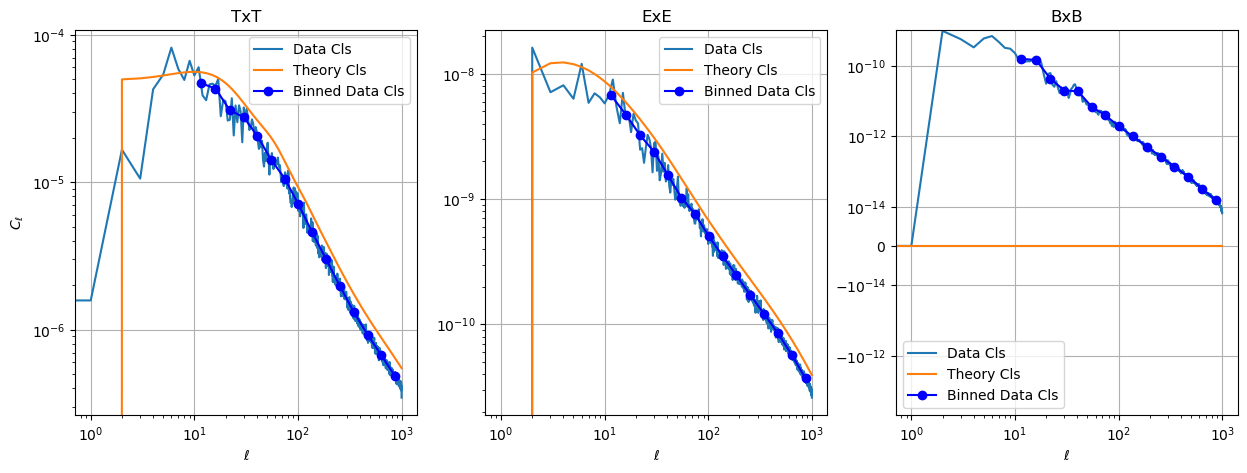

In [18]:
figure, axis = plt.subplots(1, 3, figsize=(5*3, 5))
for i, s1 in enumerate(fields_a):
    proposed_key = '{}{}'.format(s1, s1)
    print(proposed_key)
    t = theory_cls[proposed_key]
    d = data_cls[proposed_key]

    axis[i].plot(l, d, label="Data Cls")
    axis[i].plot(l, t, label="Theory Cls")
    axis[i].plot(q, B @ d, "bo-", label="Binned Data Cls")
    axis[i].set_xscale('log')
    if s1 == 'B':
        axis[i].set_yscale('symlog', linthresh=1e-14)
    else:
        axis[i].set_yscale('log')
    axis[i].set_title(f"{s1}x{s1}")
    axis[i].set_xlabel(r"$\ell$")
    if i == 0:
        axis[i].set_ylabel(r"$C_\ell$")
    axis[i].grid()
    axis[i].legend()
plt.show()

## Polspice

### Definitions
In the Polspice method we account for the effect of the mask in real space.
Let's start laying down some definitions. Given  a spin-2 complex field,
$$ \gamma(n) = (Q \pm i U)(n) \, ,$$
we can expand it in terms of the spherical harmonics in $E$ and $B$ modes:
$$ \gamma(n)  = \sum_{l m} (E_{l m} \mp i B_{l m}) _{\mp 2} Y_{l m}(n)  \, .$$


Then, we can define the correlators of the field as:
$$ \xi_{+} = \langle \gamma^* \gamma\rangle  \hspace{6pt}\rm{and}\hspace{6pt} \xi_{-} = \langle \gamma \gamma \rangle $$
In the presence of a mask, $w(\theta)$, the partial sky correlatiors are given by:
$$ \tilde{\xi}_{\pm}(\theta) = \xi_{\pm}(\theta) \xi^{ww'}(\theta) $$
where $\xi^{ww'}(\theta)$ is the mask correlation function.

Moreover, we can express these partial sky correlation functions in terms of linear combinations of the measured $E$ and $B$ angular power spectra:
$$  \tilde{\xi}_{\pm}(\theta) = \sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l \pm  \tilde{C}^{BB}_l) d^l_{2 \pm 2}(\theta) \, , $$
where $d^l_{2 \pm 2}(\theta)$ are the Wigner matrices.

### Method

Our objective is to recover the full sky angular power spectra. For spin-0 fields this is as simple as transforming the measured partial sky power spectra to real space and dividing the resulting correlation function by the correlation function of mask. However, for spin-2 fields, the mask introduces a coupling between the $E$ and $B$ modes which needs to be undone.

The PolSpice method undoes the $E-B$ coupling by defining a correlator akin to $\xi_{+}(\theta)$ but with the Wigner matrix of a spin -2 field:
$$
\xi_{\rm dec}(\theta) = \frac{\tilde{\xi}_{\rm dec}(\theta)}{\xi^{ww'}(\theta)} = \nonumber \\
= \frac{1}{\xi^{ww'}(\theta)} \sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l +  \tilde{C}^{BB}_l) d^l_{2 - 2}(\theta)
$$

Then one can construct a estimator for the full sky angular correlation functions by combining the correlation function and inverting the SWSH transform:
$$
C^{EE}_l = 2\pi \int \frac{1}{2}[\xi_{\rm dec}(\theta) + \xi_{-}(\theta)] d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} $$
$$
C^{BB}_l = 2\pi \int \frac{1}{2}[\xi_{\rm dec}(\theta) - \xi_{-}(\theta)] d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} $$

### Equation 90

As pointed out by Eric Hivon, $\xi_{\rm dec}(\theta)$ can be computed using the expression:
$$
\xi_{\rm dec}(\theta) = \xi_+ (\theta) + \frac{1}{\sin^2(\theta/2)} \int^1_{\cos \theta} d \cos \theta' \xi_+(\theta') \sec^4 (\theta'/2) + \\
-\frac{2(2+\cos \theta)}{\sin^4(\theta/2)} \int^1_{\cos \theta} d \cos \theta' \xi_+(\theta') \frac{\tan^3 (\theta'/2)}{\sin \theta'} \, .
$$
We can write completely in terms of $x=\cos \theta$:
$$  
\xi_{\rm dec}(x) = \xi_+ (x) + \left(\frac{8}{(1-x)^2}\right) \left( (1-x)\int^1_{x} dx' \frac{\xi_+(x')}{(1-x')^2}  \, - (2+x) \left( \int^1_x dx' \xi_+(x') \frac{1-x^2}{(1+x)^3}\right) \right) \, .\\
$$
This way we can see that this expression is problematic for $x=1$ and $x=-1$.



In [56]:
from scipy.interpolate import interp1d

def Eq90(cos_theta, xi_p):
    xi_pi = interp1d(cos_theta, xi_p, kind='linear', fill_value="extrapolate")
    #x = np.linspace(-0.9999, 0.9995, 101)
    x = np.linspace(cos_theta[0], cos_theta[-1], 100000000)
    xi_p = xi_pi(x)
    dx = x[1] - x[0]
    eps = 1e-5

    prefac = 8/((1-x + eps)**2)

    prefac1 = (1-x)
    print(prefac1)
    integ1 = dx * xi_p * (1/((1+x+eps)**2))
    int1 = np.cumsum(integ1[::-1])[::-1]
    int1 = np.append(int1[1:], 0)
    t1 = prefac1 * int1

    prefac2 = (2+x)
    integ2 = dx * xi_p * ((1-x**2)/((1+x+eps)**3))
    int2 = np.cumsum(integ2[::-1])[::-1]
    int2 = np.append(int2[1:], 0)
    t2 = prefac2 * int2
    
    eq90 = xi_p + prefac *(t1 - t2)
    eq90_i = interp1d(x, eq90, kind='linear', fill_value="extrapolate")
    eq90 = eq90_i(cos_theta)
    return eq90

In [57]:
#Polspice
# Compute the correlation function of the data
prefac = l * (l + 1) / (2 * np.pi)
cls_for_corr = np.array([
    data_cls['TT'],
    data_cls['EE'],
    data_cls['BB'],
    #theory_cls['EE'],
    #theory_cls['BB'],
    np.zeros(lmax+1)])
cls_for_corr *= prefac
data_corr, corr_x, corr_w = glc(cls_for_corr.T,
                                lmax=lmax,
                                sampling_factor=1)
data_corr[:, 0] += data_cls['TT'][0]/(4*np.pi)
xi_TT = data_corr.T[0]
xi_p  = data_corr.T[1]
xi_m  = data_corr.T[2]

# Compute the correlation function of the mask
mask_for_corr = np.transpose([
  mask_cls * prefac,
  np.zeros(lmax+1),
  np.zeros(lmax+1),
  np.zeros(lmax+1)])
mask_corr, mask_corr_x, mask_corr_w = glc(mask_for_corr,
                                          lmax=lmax,
                                          sampling_factor=1)
mask_corr[:, 0] += mask_cls[0]/(4*np.pi)
xi_mask = mask_corr.T[0]

# Cls for Xi_dec
cls_for_dec = np.array([
    np.zeros(lmax+1),
    theory_cls['EE'],
    -theory_cls['BB'],
    #data_cls['EE'],
    #-data_cls['BB'],
    np.zeros(lmax+1)])
cls_for_dec *= prefac
dec_corr, _, _ = glc(cls_for_dec.T,
                      lmax=lmax,
                      sampling_factor=1)
xi_dec = dec_corr.T[2]

# Cls for Xi_dec
data_cls_for_dec = np.array([
    np.zeros(lmax+1),
    #theory_cls['EE'],
    #-theory_cls['BB'],
    data_cls['EE'],
    -data_cls['BB'],
    np.zeros(lmax+1)])
data_cls_for_dec *= prefac
data_dec_corr, _, _ = glc(data_cls_for_dec.T,
                      lmax=lmax,
                      sampling_factor=1)
data_xi_dec = data_dec_corr.T[2]/xi_mask

# Eq90
xi_eq90 = Eq90(corr_x, xi_p/xi_mask)
# silly test
#xi_eq90[900:] = xi_dec[900:]

# Transform back to Cl
pols_corrs = np.array([
    xi_TT/xi_mask,
    #xi_p,
    xi_p/xi_mask,     #xi_EE_camb,
    xi_dec,   #xi_BB_camb,
    np.zeros(lmax+1)])
pols_cls_list = camb.correlations.corr2cl(pols_corrs.T,
                                          corr_x, corr_w, lmax)
prefac[0] = 1
pols_cls_list = pols_cls_list.T/prefac

pols_cls = {}
pols_cls['TT'] = pols_cls_list[0]
pols_cls['EE'] = pols_cls_list[1]
# Off by minus sign
pols_cls['BB'] = -pols_cls_list[2]

# Transform back to Cl
pols_corrs = np.array([
    xi_TT/xi_mask,
    xi_p/xi_mask,  #xi_EE_camb,
    data_xi_dec,   #xi_BB_camb,
    np.zeros(lmax+1)])
pols_cls_list = camb.correlations.corr2cl(pols_corrs.T,
                                          corr_x, corr_w, lmax)
prefac[0] = 1
pols_cls_list = pols_cls_list.T/prefac

data_pols_cls = {}
data_pols_cls['TT'] = pols_cls_list[0]
data_pols_cls['EE'] = pols_cls_list[1]
# Off by minus sign
data_pols_cls['BB'] = -pols_cls_list[2]

# Transform back to Cl
pols_corrs = np.array([
    xi_TT/xi_mask,
    xi_p/xi_mask,   #xi_EE_camb,
    xi_eq90,        #xi_BB_camb,
    np.zeros(lmax+1)])
pols_cls_list = camb.correlations.corr2cl(pols_corrs.T,
                                          corr_x, corr_w, lmax)
prefac[0] = 1
pols_cls_list = pols_cls_list.T/prefac

eq90_pols_cls = {}
eq90_pols_cls['TT'] = pols_cls_list[0]
eq90_pols_cls['EE'] = pols_cls_list[1]
# Off by minus sign
eq90_pols_cls['BB'] = -pols_cls_list[2]

[1.99999712e+00 1.99999710e+00 1.99999708e+00 ... 2.92293594e-06
 2.90293600e-06 2.88293606e-06]


In [58]:
a = [i**2 for i in range(1, 10)]
b = np.cumsum(a[::-1])[::-1]
b = np.append(b[1:], 0)
print(a)
print(b)
print(np.sum(a))   

[1, 4, 9, 16, 25, 36, 49, 64, 81]
[284 280 271 255 230 194 145  81   0]
285


In [59]:
xi_eq90

array([ 3.37966003e-05, -9.67564469e-06,  1.63468269e-06, ...,
        8.20312259e-07,  5.33712534e-07,  5.72782078e-06])

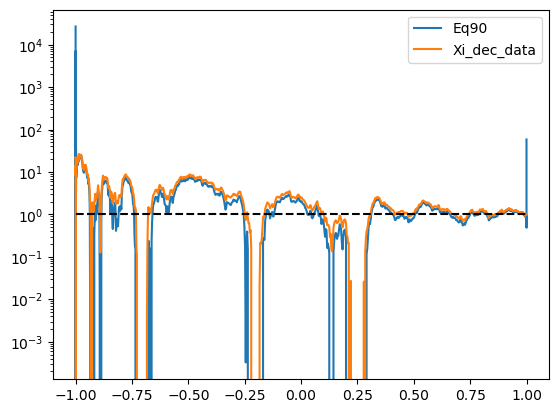

In [60]:
plt.plot(corr_x, xi_eq90/xi_dec, label="Eq90")
plt.plot(corr_x, data_xi_dec/xi_dec, label="Xi_dec_data")
plt.plot(corr_x, np.ones_like(corr_x), 'k--')
plt.legend()
plt.yscale('log')

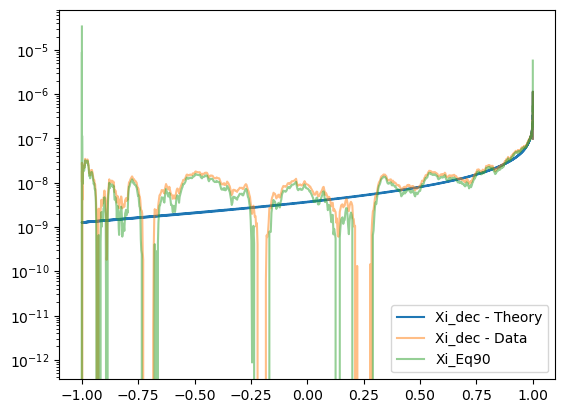

In [61]:
plt.plot(corr_x, xi_dec, label="Xi_dec - Theory")
plt.plot(corr_x, data_xi_dec, alpha=0.5, label="Xi_dec - Data")
#plt.plot(corr_x, xi_p, alpha=0.5, label="Xi_p")
plt.plot(corr_x, xi_eq90, alpha=0.5, label="Xi_Eq90")
#plt.xlim(0.75, 1)
plt.yscale('log')
plt.legend()

TT
EE
BB


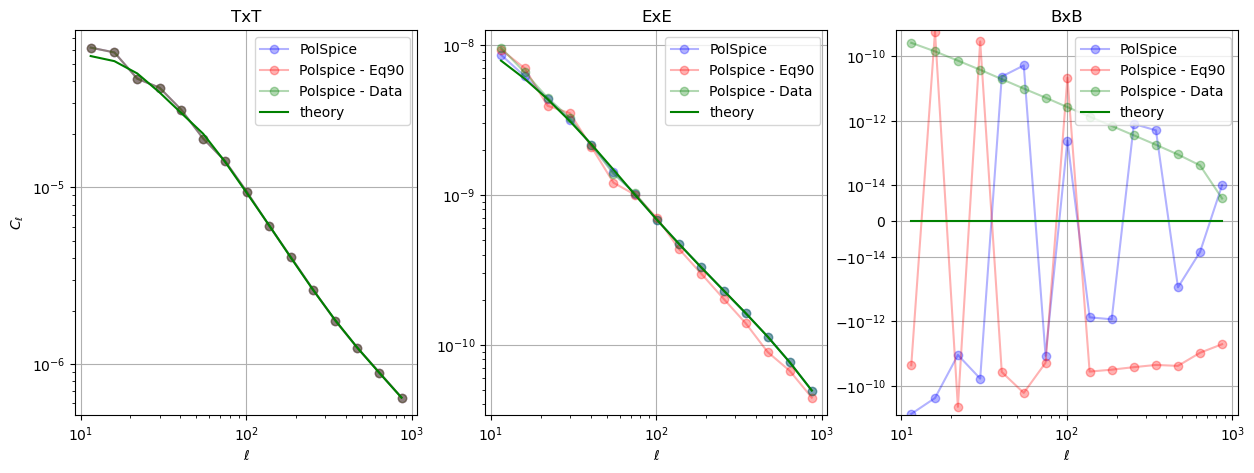

In [62]:
figure, axis = plt.subplots(1, 3, figsize=(5*3, 5))
for i, s1 in enumerate(fields_a):
    proposed_key = '{}{}'.format(s1, s1)
    print(proposed_key)
    t    = theory_cls[proposed_key]
    d_p  = pols_cls[proposed_key]
    d_eq = eq90_pols_cls[proposed_key]
    d_d  = data_pols_cls[proposed_key]

    axis[i].plot(q, B @ d_p, 'bo-', alpha=0.3, label="PolSpice")
    axis[i].plot(q, B @ d_eq, 'ro-', alpha=0.3, label="Polspice - Eq90")
    axis[i].plot(q, B @ d_d, 'go-', alpha=0.3, label="Polspice - Data")
    axis[i].plot(q, B @ t, 'g-', label="theory")
    axis[i].set_xscale('log')
    if s1 == 'B':
        axis[i].set_yscale('symlog', linthresh=1e-14)
    else:
        axis[i].set_yscale('log')
    axis[i].set_title(f"{s1}x{s1}")
    axis[i].set_xlabel(r"$\ell$")
    if i == 0:
        axis[i].set_ylabel(r"$C_\ell$")
    axis[i].grid()
    axis[i].legend()
plt.show()

### Our problem
This approach gives us a very good agreement with the theory prediction for the full sky angular power spectra for the spin-0 and for the E-mode of the spin-2 field. However, we see a substantial E-leakage into the B-mode.

### Trying to understand the E-leakage

In order to understand what might be going on let us inspect the $C^{BB}_l$ and express it in terms of the correlation functions of the E- and B-modes:
$$
C^{BB}_l = 2\pi \int \frac{1}{2}[\xi_{\rm dec}(\theta) - \xi_{-}(\theta)] d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta}  = \, \nonumber \\ = 2\pi \int \frac{1}{2\xi^{ww'}(\theta)}[\left(\sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l +  \tilde{C}^{BB}_l) d^l_{2 - 2}(\theta)\right) \nonumber \\ - \left(\sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l - \tilde{C}^{BB}_l) d^l_{2 -2}(\theta)\right)] d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta}  =  \, \nonumber \\
= 2\pi \int \frac{1}{\xi^{ww'}(\theta)} \left(\sum_l \frac{2l+1}{4\pi} \tilde{C}^{BB}_l d^l_{2 - 2}(\theta)\right) d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} = \nonumber \\
= 2\pi \int \frac{\xi^{BB}(\theta)}{\tilde{\xi}^{ww'}(\theta)}  d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} \, .
$$
We can see that no E-mode information are subtracted from $C^{BB}_l$ this approach.

We can perform a similar expansion for the E-mode expression. First allows us to write $\tilde{\xi}_{\rm dec}(\theta)$ in terms of $\tilde{\xi}_{-}(\theta)$. This can be done by adding and subtracting $\tilde{C}^{BB}_l$:
$$
\tilde{\xi}_{\rm dec}(\theta) =  \sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l +  \tilde{C}^{BB}_l + \tilde{C}^{BB}_l - \tilde{C}^{BB}_l) d^l_{2 - 2}(\theta)  = \nonumber \\ =  \tilde{\xi}_{-}(\theta) + 2 \sum_l \frac{2l+1}{4\pi} \tilde{C}^{BB}_l d^l_{2-2}(\theta)
$$
Now, plugging these two equations into each other:
$$
C^{EE}_l = 2\pi \int \frac{1}{2}[\xi_{\rm dec}(\theta) + \xi_{-}(\theta)] d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} = \nonumber \\  
= 2\pi \int \frac{1}{2 \xi^{ww'}(\theta)}\left(2 \tilde{\xi}_{-}(\theta) + 2\sum_l \frac{2l+1}{4\pi}\tilde{C}^{BB}_l d^l_{2 -2}(\theta)\right) d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} \,  \nonumber \\
= 2\pi \int \xi_{-}(\theta) d^{l}_{2-2} {\rm d}\!\cos{\theta} + C_l^{BB}
$$
which shows the expected mixing.

### Possible solutions
Alternatively, we could construct a series of estimators which exhibit mixing for both $C^{EE}_l$ and $C^{BB}_l$. In order to do so let us define the angular power spectra:
$$
C_l^{\pm} = C_l^{EE} \pm C_l^{BB} = \nonumber \\
= 2 \pi \int \frac{1}{\xi^{ww'}(\theta)} \left( \sum_l \frac{2l+1}{4\pi} (\tilde{C}_l^E \pm \tilde{C}_l^B) d^l_{2\pm2}\right) d^l_{2\pm2} {\rm d}\cos{\theta}
$$
Then the respective estimators for the uncoupled E and B fields can be obtained by considering:
$$
C_l^{EE} = \frac{1}{2}(C_l^{+} + C_l^{-}) \,, \\
C_l^{BB} = \frac{1}{2}(C_l^{+} - C_l^{-}) \,  .
$$

We will refer to this method as the "Naive PolSpice" method.

In [26]:
#Naive Polspice
naive_pols_corrs = np.array([
    xi_TT/xi_mask,
    xi_p/xi_mask,
    xi_m/xi_mask,
    np.zeros(lmax+1)])
naive_pols_cls_list = camb.correlations.corr2cl(naive_pols_corrs.T,
                                                corr_x, corr_w, lmax)
prefac[0] = 1
naive_pols_cls_list = naive_pols_cls_list.T/prefac

naive_pols_cls = {}
naive_pols_cls['TT'] = naive_pols_cls_list[0]
naive_pols_cls['EE'] = naive_pols_cls_list[1]
naive_pols_cls['BB'] = naive_pols_cls_list[2]


TT
EE
BB


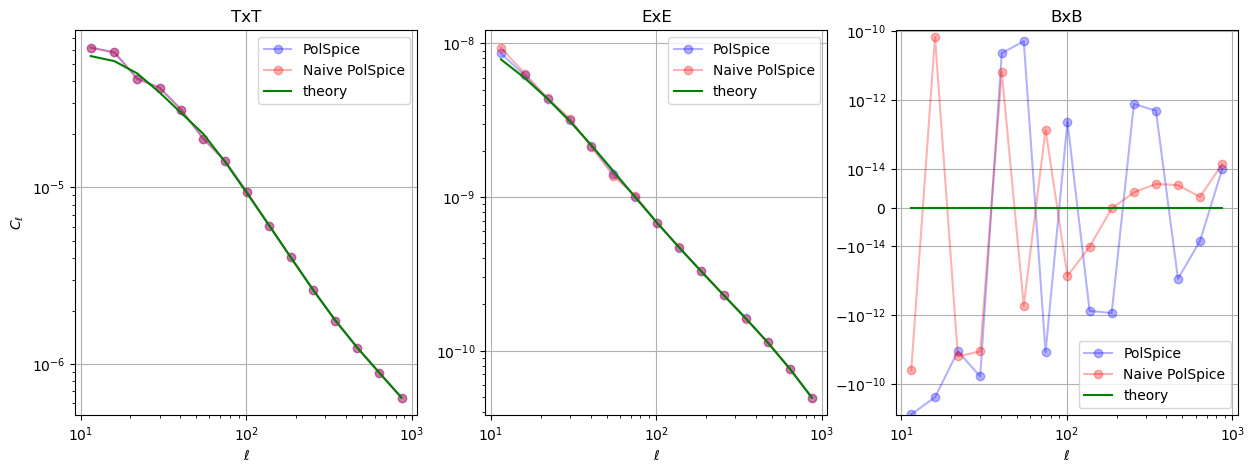

In [27]:
figure, axis = plt.subplots(1, 3, figsize=(5*3, 5))
for i, s1 in enumerate(fields_a):
    proposed_key = '{}{}'.format(s1, s1)
    print(proposed_key)
    t    = theory_cls[proposed_key]
    d_p  = pols_cls[proposed_key]
    d_np = naive_pols_cls[proposed_key]

    axis[i].plot(q, B @ d_p, 'bo-', alpha=0.3, label="PolSpice")
    axis[i].plot(q, B @ d_np, 'ro-', alpha=0.3, label="Naive PolSpice")
    axis[i].plot(q, B @ t, 'g-', label="theory")
    axis[i].set_xscale('log')
    if s1 == 'B':
        axis[i].set_yscale('symlog', linthresh=1e-14)
    else:
        axis[i].set_yscale('log')
    axis[i].set_title(f"{s1}x{s1}")
    axis[i].set_xlabel(r"$\ell$")
    if i == 0:
        axis[i].set_ylabel(r"$C_\ell$")
    axis[i].grid()
    axis[i].legend()
plt.show()

As we can see the Naive Polspice method matches the theory predictions of the spinn-0 and the E-mode just as well as the traditional PolSpice method. Moreover, it manages to remove the E-leakage from the B-mode.

### Questions
- Have we missed something in the derivation of the traditional PolSpice method that could be responsible for the leakage of E-modes into the B-mode?
- Is the Naive PolSpice method a valid alternative to the traditional PolSpice method?
- If so, why is not the default method?

Thank you so much!